## Performance Window Example
---

* Roll Rate Analysis
* Vintage Analysis

In [1]:
import sys, os
sys.path.insert(1, "..")
import numpy as np
import pandas as pd
import ml4risk.model_design.performance_window as pw
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn")

%load_ext autoreload
%autoreload 2

### Query Data

In [2]:
pstr_df = pd.read_parquet("s3://sofi-data-science/jxu/pl-gen4/data_dump/archive/bad-def-n-perf-window/payment_str.parquet")

In [3]:
pstr_df.head()

,id,days_past_due,pl_custom_score,bankruptcy,charge_off_date,fico_score,confirmed_fraud,deliq_30p_90days,loan_id,initial_term,...,bad90dpd,status18,status6after18,status3after18,status3after20,status20,status6after20,status6after24,status3after24,status24
0,222181,0,414.0,0,None,718,0,0,31706,5,...,0,C,C,C,C,C,C,C,C,C
1,222212,0,328.0,0,None,705,0,0,31466,3,...,0,P,P,P,P,P,P,P,P,P
2,222220,0,390.0,0,None,775,0,0,31467,7,...,0,C,C,C,C,C,C,C,C,C
3,222225,0,338.0,0,None,751,0,0,31434,7,...,0,C,C,C,C,C,C,C,C,C
4,222301,0,319.0,0,None,753,0,0,31435,7,...,0,C,C,C,C,C,C,C,C,C


## Roll-Rate Analysis
---

To get Roll Rate, follow the following steps:

For example if we want to look at `loan status 6 months after 18 months`, let's 
1. get status at month 18 from `status_string`
2. get status at month 24 (18+6) 
3. jog down the exclusion status characters.
4. get transtion table. Example shown below

#### Experiment with status6after18

In [4]:
# step 0: define status string mapping function
#   default: pw.get_loan_status
# step 1
pstr_df["status18_new"] = pw.get_payment_status_month_k(pstr_df["status_string"], 18, return_last=True)

# step 2
pstr_df["status6after18_new"] = pw.get_payment_status_month_k(pstr_df["status_string"], 24, return_last=True)

# step 3
exclusions = list("XUMFN")  # ['X', 'U', 'M', 'F', 'N']

# step 4
new = pw.get_status_transition_table(pstr_df, "status18_new", "status6after18_new", exclusion=exclusions)
new

status6after18_new,1-29DPD,30-59DPD,60-89DPD,90-119DPD,CURRENT,DEFAULT,P,All
status18_new,,,,,,,,
1-29DPD,561,134,95,87,785,961,129,2752
30-59DPD,78,54,75,83,243,1205,32,1770
60-89DPD,27,32,61,77,108,1632,13,1950
90-119DPD,7,13,30,57,58,1211,7,1383
CURRENT,2069,1353,1442,1069,304831,3964,36534,351262
DEFAULT,0,0,0,0,0,16072,6,16078
P,0,0,0,0,0,1,89107,89108
All,2742,1586,1703,1373,306025,25046,125828,464303


In [5]:
# if we want to normalize the counts to get percentage
new = pw.get_status_transition_table(pstr_df, "status18_new", "status6after18_new", 
                                     normalize=True, exclusion=exclusions).round(4)*100
new  

status6after18_new,1-29DPD,30-59DPD,60-89DPD,90-119DPD,CURRENT,DEFAULT,P,All
status18_new,,,,,,,,
1-29DPD,20.39,4.87,3.45,3.16,28.52,34.92,4.69,100.0
30-59DPD,4.41,3.05,4.24,4.69,13.73,68.08,1.81,100.0
60-89DPD,1.38,1.64,3.13,3.95,5.54,83.69,0.67,100.0
90-119DPD,0.51,0.94,2.17,4.12,4.19,87.56,0.51,100.0
CURRENT,0.59,0.39,0.41,0.30,86.78,1.13,10.40,100.0
DEFAULT,0.00,0.00,0.00,0.00,0.00,99.96,0.04,100.0
P,0.00,0.00,0.00,0.00,0.00,0.00,100.00,100.0
All,0.59,0.34,0.37,0.30,65.91,5.39,27.10,100.0


### Customized String Mapping function
---

In [6]:
# step 0: define status string mapping function
#   default: pw.get_loan_status

def status_code_mapper(status_code: str) -> str:
    """get loan status from the perf_var/encoded str

    @params status_code - str
        individual char indicating status for payment strings
    @returns status - str
        status grouped for business strategy purposes
    """
    from collections import defaultdict as ddict
    mapper = {
        "C": "CURRENT",
        "1": "1-29DPD",
        "2": "1-29DPD",
        "3": "30-59DPD",
        "4": "60-89DPD",
        "5": "90-119DPD",
        "6": "120+DPD",
        "B": "DEFAULT",
        "D": "DEFAULT",
        "W": "DEFAULT",
    }

    mapper = ddict(lambda: "_UNK_", mapper)

    return mapper[status_code]

# step 1
pstr_df["status18_new"] = pw.get_payment_status_month_k(pstr_df["status_string"], 18, return_last=True, status_fn=status_code_mapper)

# step 2
pstr_df["status6after18_new"] = pw.get_payment_status_month_k(pstr_df["status_string"], 24, return_last=True, status_fn=status_code_mapper)

# step 3
exclusions = list("XUMFN")  # ['X', 'U', 'M', 'F', 'N']

# step 4
new = pw.get_status_transition_table(pstr_df, "status18_new", "status6after18_new", exclusion=exclusions)
new

status6after18_new,1-29DPD,120+DPD,30-59DPD,60-89DPD,90-119DPD,CURRENT,DEFAULT,_UNK_,All
status18_new,,,,,,,,,
1-29DPD,561,0,134,95,87,785,961,141,2764
120+DPD,0,0,0,0,0,0,1,0,1
30-59DPD,78,1,54,75,83,243,1204,36,1774
60-89DPD,27,0,32,61,77,108,1632,14,1951
90-119DPD,7,0,13,30,57,58,1211,11,1387
CURRENT,2069,0,1353,1442,1069,304831,3964,38231,352959
DEFAULT,0,0,0,0,0,0,16071,6,16077
_UNK_,54,0,48,49,41,1402,109,89453,91156
All,2796,1,1634,1752,1414,307427,25153,127892,468069


## Vintage Analysis
---

In [11]:
loan_df = pd.read_parquet("s3://sofi-data-science/jxu/pl-gen4/data_dump/archive/bad-def-n-perf-window/loan_data.parquet")
loan_df.head()

,loan_id,id,applicant_id,commonline_id,current_owner,current_owner_name,current_owner_type,application_type,loan_type,current_prin,...,initial_term,tier,confirmed_fraud,ineligible,orig_gross_int_rate,original_prin,sofiinq,deliq_30p_90days,seasoning,date_application
0,42453,305048,85633,305048,100401,SoFi Consumer Loan Funding 2015-1 Trust,whole loan,PL,PL,0.0,...,3,3,0,0,0.07365,20000.0,NaN,0,73,2015-05-01
1,42453,305048,85633,305048,100401,SoFi Consumer Loan Funding 2015-1 Trust,whole loan,PL,PL,0.0,...,3,3,0,0,0.07365,20000.0,NaN,0,73,2015-05-01
2,42453,305048,85633,305048,100401,SoFi Consumer Loan Funding 2015-1 Trust,whole loan,PL,PL,0.0,...,3,3,0,0,0.07365,20000.0,NaN,0,73,2015-05-01
3,42453,305048,85633,305048,100401,SoFi Consumer Loan Funding 2015-1 Trust,whole loan,PL,PL,0.0,...,3,3,0,0,0.07365,20000.0,NaN,0,73,2015-05-01
4,42453,305048,85633,305048,100401,SoFi Consumer Loan Funding 2015-1 Trust,whole loan,PL,PL,0.0,...,3,3,0,0,0.07365,20000.0,NaN,0,73,2015-05-01


#### Some data processing

In [12]:
loan_df['origination_date']=pd.to_datetime(loan_df.origination_date)
loan_df['asof_date']=pd.to_datetime(loan_df.asof_date)
loan_df=loan_df[loan_df.confirmed_fraud==0]

loan_df['quarter'] = pd.PeriodIndex(loan_df.origination_date, freq='Q').astype(str)    
loan_df['year'] = pd.PeriodIndex(loan_df.origination_date, freq='Y').astype(str)
loan_df['mmm'] = pd.PeriodIndex(loan_df.origination_date, freq='M').astype(str)

#### Bad definition

In [13]:
loan_df['target']= np.where((loan_df.loan_status.isin( ["BANKRUPTCY", "CHARGE OFF", "WRITE OFF"])) | 
                            (loan_df['days_past_due'] >= 60), 1, 0)

### Manual
---

Input data:
* loan monthly data, each row contains the status of a single loan at one month.

There are 3 steps:
1. compute `is_first_bad` flag on the input dataframe. `df[is_first_bad] == 1` if the loan turned bad on that month.
2. compute aggregations
    * provided `id_col`, `seasoning_col`, `first_bad_col`, compute `nr_bad`, `br_inc`
    * (optional) given `bal_col`, compute `bal_bad`, `br_inc_bal`
    * (optional) given `group_col`, compute the above grouped by unique values in `df[group_col]`
3. plot

#### Example 1: Plot Combined Bad Rate

,seasoning_orig,nr_bad,br_inc,br_cum
0,0,0,0.000000,0.000000
1,1,10,0.000024,0.000024
2,2,53,0.000129,0.000153
3,3,291,0.000708,0.000861
4,4,441,0.001073,0.001934


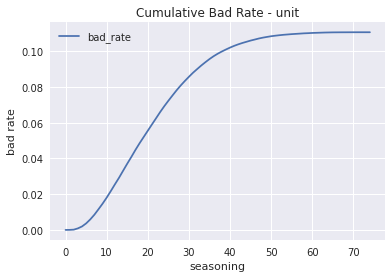

In [14]:
# step 0: setup
id_col, season_col, bad_col = "id", "seasoning_orig", "target"

# step 1
loan_df["is_first_bad"] = pw.get_first_bad(loan_df, id_col, season_col, bad_col)

# step 2
agg = pw.get_incremental_bads(loan_df, id_col, season_col, "is_first_bad")
display(agg.head())

# step 3
fig, ax = plt.subplots(figsize=(6, 4))
pw.plot_cum_curve(agg, season_col, "br_cum", fig=fig, ax=ax, label="bad_rate")
plt.title("Cumulative Bad Rate - unit")
plt.legend()
plt.xlabel("seasoning")
plt.ylabel("bad rate")
plt.show()

#### Example 2: Plot Combined Bad Rate, by counts and dollar value

,seasoning_orig,nr_bad,br_inc,br_cum,bal_bad,br_inc_bal,br_cum_bal
0,0,0,0.000000,0.000000,0.00,0.000000,0.000000
1,1,10,0.000024,0.000024,319636.50,0.000023,0.000023
2,2,53,0.000129,0.000153,1602585.77,0.000116,0.000139
3,3,291,0.000708,0.000861,8085675.08,0.000585,0.000724
4,4,441,0.001073,0.001934,13218981.73,0.000957,0.001681


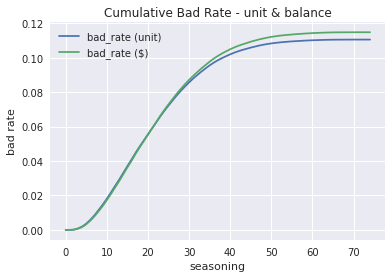

In [15]:
# step 0: setup
id_col, season_col, bad_col = "id", "seasoning_orig", "target"
balance_col = "original_prin"

# step 1
loan_df["is_first_bad"] = pw.get_first_bad(loan_df, id_col, season_col, bad_col)

# step 2
agg = pw.get_incremental_bads(loan_df, id_col, season_col, "is_first_bad", balance_col)
display(agg.head())

# step 3
fig, ax = plt.subplots(figsize=(6, 4))
pw.plot_cum_curve(agg, season_col, "br_cum", fig=fig, ax=ax, label="bad_rate (unit)")
pw.plot_cum_curve(agg, season_col, "br_cum_bal", fig=fig, ax=ax, label="bad_rate ($)")
plt.title("Cumulative Bad Rate - unit & balance")
plt.legend()
plt.xlabel("seasoning")
plt.ylabel("bad rate")
plt.show()

#### Example 3: Plot Unit Bad Rate, segmented by term length = 3, 5, 7

100%|██████████| 6/6 [00:15<00:00,  2.66s/it]


,seasoning_orig,nr_bad,br_inc,br_cum,bal_bad,br_inc_bal,br_cum_bal,initial_term
0,0,0,0.000000,0.000000,0.00,0.000000,0.000000,3
1,1,3,0.000034,0.000034,43545.16,0.000019,0.000019,3
2,2,9,0.000102,0.000136,199216.88,0.000087,0.000106,3
3,3,47,0.000531,0.000667,851470.15,0.000372,0.000479,3
4,4,75,0.000848,0.001515,1895199.11,0.000829,0.001308,3


  0%|          | 0/3 [00:00<?, ?it/s]

07/07/2021 07:43:06 PM: Overwritting provided label since we have multiple groups
07/07/2021 07:43:06 PM: Overwritting provided label since we have multiple groups


100%|██████████| 3/3 [00:00<00:00, 662.71it/s]


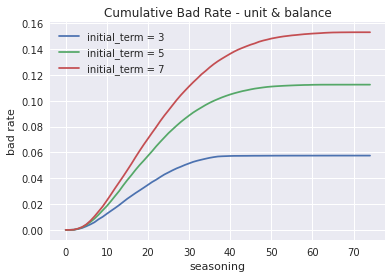

In [16]:
# step 0: setup
id_col, season_col, bad_col = "id", "seasoning_orig", "target"
balance_col = "original_prin"
group_col = "initial_term"

# step 1
loan_df["is_first_bad"] = pw.get_first_bad(loan_df, id_col, season_col, bad_col)

# step 2
agg = pw.get_incremental_bads(loan_df, id_col, season_col, "is_first_bad", 
                              bal_col=balance_col, group_col=group_col)
agg = agg[agg.initial_term.isin([3, 5, 7])]
display(agg.head())

# step 3
fig, ax = plt.subplots(figsize=(6, 4))
pw.plot_cum_curve(agg, season_col, "br_cum", group_col=group_col,
                  fig=fig, ax=ax)
plt.title("Cumulative Bad Rate - unit & balance")
plt.legend()
plt.xlabel("seasoning")
plt.ylabel("bad rate")
plt.show()

#### Example 4: Plot Unit Bad Rate, segmented by origination year 

100%|██████████| 5/5 [00:19<00:00,  3.96s/it]


,seasoning_orig,nr_bad,br_inc,br_cum,bal_bad,br_inc_bal,br_cum_bal,year
0,0,0,0.000000,0.000000,0.00,0.000000,0.000000,2015
1,1,2,0.000050,0.000050,72217.00,0.000048,0.000048,2015
2,2,2,0.000050,0.000100,70100.00,0.000047,0.000095,2015
3,3,24,0.000599,0.000699,661199.34,0.000442,0.000537,2015
4,4,52,0.001298,0.001996,1728792.87,0.001155,0.001692,2015


  0%|          | 0/5 [00:00<?, ?it/s]

07/07/2021 07:43:32 PM: Overwritting provided label since we have multiple groups
07/07/2021 07:43:32 PM: Overwritting provided label since we have multiple groups
07/07/2021 07:43:32 PM: Overwritting provided label since we have multiple groups
07/07/2021 07:43:32 PM: Overwritting provided label since we have multiple groups


100%|██████████| 5/5 [00:00<00:00, 595.36it/s]


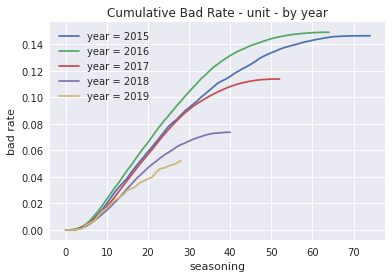

In [17]:
# step 0: setup
id_col, season_col, bad_col = "id", "seasoning_orig", "target"
balance_col = "original_prin"
group_col = "year"

# step 1
loan_df["is_first_bad"] = pw.get_first_bad(loan_df, id_col, season_col, bad_col)

# step 2
agg = pw.get_incremental_bads(loan_df, id_col, season_col, "is_first_bad", 
                              bal_col=balance_col, group_col=group_col)
display(agg.head())

# step 3
fig, ax = plt.subplots(figsize=(6, 4))
pw.plot_cum_curve(agg, season_col, "br_cum", group_col=group_col,
                  fig=fig, ax=ax)
plt.title("Cumulative Bad Rate - unit - by year")
plt.legend()
plt.xlabel("seasoning")
plt.ylabel("bad rate")
plt.show()

#### Example 5: Plot Unit Bad Rate, both cumulative and incremental

100%|██████████| 6/6 [00:17<00:00,  2.85s/it]


,seasoning_orig,nr_bad,br_inc,br_cum,bal_bad,br_inc_bal,br_cum_bal,initial_term
0,0,0,0.000000,0.000000,0.00,0.000000,0.000000,3
1,1,3,0.000034,0.000034,43545.16,0.000019,0.000019,3
2,2,9,0.000102,0.000136,199216.88,0.000087,0.000106,3
3,3,47,0.000531,0.000667,851470.15,0.000372,0.000479,3
4,4,75,0.000848,0.001515,1895199.11,0.000829,0.001308,3


  0%|          | 0/3 [00:00<?, ?it/s]

07/07/2021 07:43:54 PM: Overwritting provided label since we have multiple groups
07/07/2021 07:43:54 PM: Overwritting provided label since we have multiple groups


  0%|          | 0/3 [00:00<?, ?it/s]

07/07/2021 07:43:54 PM: Overwritting provided label since we have multiple groups
07/07/2021 07:43:54 PM: Overwritting provided label since we have multiple groups


100%|██████████| 3/3 [00:00<00:00, 716.44it/s]


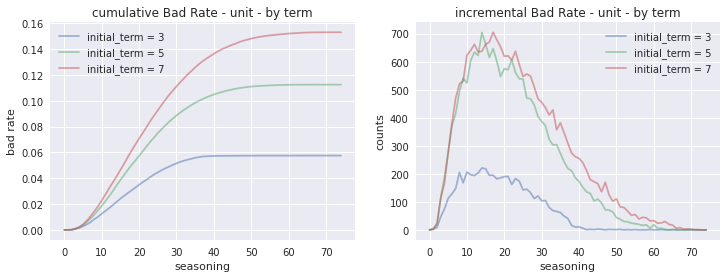

In [18]:
# step 0: setup
id_col, season_col, bad_col = "id", "seasoning_orig", "target"
balance_col = "original_prin"
group_col = "initial_term"

# step 1
loan_df["is_first_bad"] = pw.get_first_bad(loan_df, id_col, season_col, bad_col)

# step 2
agg = pw.get_incremental_bads(loan_df, id_col, season_col, "is_first_bad", 
                              bal_col=balance_col, group_col=group_col)
agg = agg[agg.initial_term.isin([3, 5, 7])]
display(agg.head())


# step 3
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

pw.plot_cum_curve(agg, season_col, "br_cum", group_col=group_col,
                  fig=fig, ax=ax[0], alpha=0.5)
ax[0].set_title("cumulative Bad Rate - unit - by term")
ax[0].legend()
ax[0].set_xlabel("seasoning")
ax[0].set_ylabel("bad rate")

pw.plot_cum_curve(agg, season_col, "nr_bad", group_col=group_col,
                  fig=fig, ax=ax[1], alpha=0.5)
ax[1].set_title("incremental Bad Rate - unit - by term")
ax[1].legend()
ax[1].set_xlabel("seasoning")
ax[1].set_ylabel("counts")

plt.show()